## 1. Forward Problem

5자유도 M,C,K 모델에 정현파 하중이 가해질 때 응답변위를 구하고자 한다.

질량 행렬은 다음과 같다.

In [1]:
from numpy import *
from matplotlib.pyplot import *
from scipy.linalg import expm
from numpy.linalg import *

In [2]:
M = 50*identity(5)

강성 행렬은 다음과 같다.

In [3]:
K = 2e6*array([[ 1, -1,  0,  0,  0],
               [-1,  2, -1,  0,  0],
               [ 0, -1,  2, -1,  0],
               [ 0,  0, -1,  2, -1],
               [ 0,  0,  0, -1,  2]])                   

모드감쇠비는 $\zeta=0.02$이다.

In [4]:
zeta = 0.02*ones(5)

감쇠행렬을 역으로 계산하기 위해 모드해석을 우선 수행한다.

모드해석을 통해 고유진동수와 모드형상을 다음과 같이 계산한다.

In [5]:
eigval, eigvec = eig(inv(M)@K)
idx = eigval.argsort()
eigval = eigval[idx]
eigvec = eigvec[:,idx]
wn = np.sqrt(eigval)
fn = wn/(2*np.pi)
ms = eigvec

모드좌표계 감쇠행렬은 다음과 같다.

In [6]:
Cn = 2*np.diag(zeta)@np.diag(wn)

전역 좌표계 감쇠행렬은 다음과 같다.

$[\phi^TM\phi]^{-1}\phi^TC\phi=C_n$

$C = [\phi^T]^{-1}[\phi^TM\phi]C_n\phi^{-1}=M\phi C_n\phi^{-1}$

In [7]:
C = M@ms@Cn@inv(ms)

5자유도 모델의 지배방정식은 다음과 같다.

$[M]\{\ddot x (t)\}+[C]\{\dot x (t)\}+[K]x(t)=\{f(t)\}$

하중 벡터는 다음과 같이 주어진다.

$\{f(t)\}=\begin{Bmatrix}0\\0\\F_0 sin(2\pi f t)\\0\\0\end{Bmatrix}$

$where,$

$F_0=2,000,000$

$f=20$

In [8]:
F0, f = 2e6, 20

## Numerical Solution (State-Space)

상태공간 방정식은 다음과 같다.

$x_{k+1}=Ax_k+Bu_k$

$where,$

$A = e^{A_c \Delta t}$

$B = [A-I]A_c^{-1}B_c$

$A_c=\begin{bmatrix} 0 & I \\ -M^{-1}K & -M^{-1}C \end{bmatrix}$

$B_c=\begin{bmatrix} 0 \\ M^{-1} \end{bmatrix}$

In [9]:
def stack(A,B):
    return concatenate([A,B],axis=0)
def augment(A,B):
    return concatenate([A,B],axis=1)

In [10]:
nm = 5 # no. of modes
no = 4 # no. of output
ni = 1 # no. of input
dt = 0.0005

om1 = zeros([nm,nm])
I1  = identity(nm)
I2  = identity(2*nm)

Ac  = augment(stack(om1,-inv(M)@K),stack(I1,-inv(M)@C))
Bc  = stack(om1,inv(M))
A   = expm(Ac*dt)
B   = (A-I2)@inv(Ac)@Bc

Sd,Sv,Sa = identity(nm),zeros([nm,nm]),zeros([nm,nm])
# Sd = np.delete(Sd,(2),axis=0)
# Sv = np.delete(Sv,(2),axis=0)
# Sa = np.delete(Sa,(2),axis=0)

G = augment(Sd-Sa@inv(M)@K, Sv-Sa@inv(M)@C)

하중벡터는 다음과 같다.

In [11]:
tmin,tmax = 0,1
N = int((tmax-tmin)/dt)+1
t = linspace(tmin,tmax,N)
u = zeros([nm,N])
u[2,:]=F0*sin(2*pi*f*t)

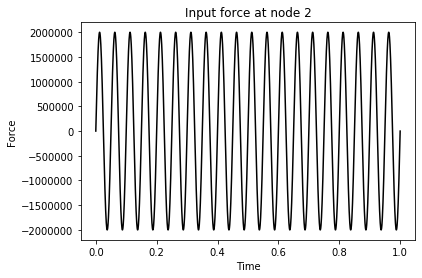

In [12]:
plot(t,u[2,:],'k-'); title('Input force at node 2'); xlabel('Time'); ylabel('Force');

초기 상태벡터를 0으로 설정하고, 상태 방정식 Itertation을 통해 상태벡터들을 구해보자.

In [13]:
x = zeros([2*nm,N])
for k in range(N-1):
    x[:,k+1] = A@x[:,k] + B@u[:,k]

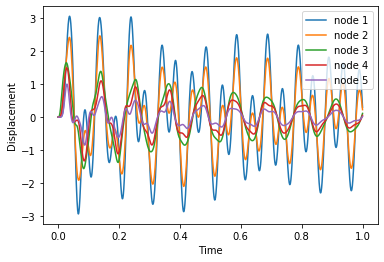

In [14]:
for i in range(5):
    plot(t,x[i,:],label="node %d"%(i+1)); legend(); xlabel('Time'); ylabel('Displacement')

## Numerical Solution (Newmark Method)

Newmark Method를 사용하여 수치해를 계산해본다.

Newmark Parameter는 다음과 같다.

$a_0=\frac{1}{\alpha \Delta t^2}$

$a_1=\frac{\delta}{\alpha \Delta t}$

$a_2=\frac{1}{\alpha \Delta t}$

$a_3=\frac{1}{2\alpha}-1$

$a_4=\frac{\delta}{\alpha}-1$

$a_5=\frac{\Delta t}{2}(\frac{\delta}{\alpha}-2)$

$\delta=\frac{1}{2}+\gamma$

$\alpha=\frac{1}{4}\left( 1+\gamma \right)^2$

$\gamma = 0.005 $ (default)

In [15]:
def NM(dt):
    gamma = 0.005; delta = 0.5050; alpha = 0.2525;
    a = ndarray(6);
    a[0] = 1/(alpha*dt*dt);   a[1] = delta/(alpha*dt);
    a[2] = 1/(alpha*dt);      a[3] = (1/(2*alpha))-1;
    a[4] = delta/alpha - 1;   a[5] = (dt/2)*(delta/alpha-2);
    
    return a

In [16]:
a = NM(dt)

Newmark Method는 다음과 같은 과정으로 진행된다.

(1) 다음 스텝의 변위 계산

$\{u_{n+1}\}=[K_e]^{-1}[F_e]$

$where,$

$[K_e]=a_0[M]+a_1[C]+[K]$

$[F_e]=\{F_{n+1}\}+[M](a_0\{u_n\} + a_2\{\dot u_n\} + a_3\{\ddot u_n\})+[C](a_1\{u_n\} + a_4\{\dot u_n\} + a_5\{\ddot u_n\})$

(2) 다음 스텝의 속도, 가속도 계산

$\{\dot u_{n+1}\}=a_1(\{u_{n+1}\}-\{u_n\}) + a_4\{\dot u_n\} + a_5\{\ddot u_n\}$

$\{\ddot u_{n+1}\}=a_0(\{u_{n+1}\}-\{u_n\}) + a_2\{\dot u_n\} + a_3\{\ddot u_n\}$

In [17]:
disp, vel, acc = zeros([nm,N]),zeros([nm,N]),zeros([nm,N])
Ke = a[0]*M + a[1]*C + K
invKe = inv(Ke)
for i in range(N-1):
    Fe = u[:,i+1] + M@(a[0]*disp[:,i]+a[2]*vel[:,i]+a[3]*acc[:,i]) + C@(a[1]*disp[:,i]+a[4]*vel[:,i]+a[5]*acc[:,i])
    disp[:,i+1] = invKe@Fe
    vel[:,i+1] = a[1]*(disp[:,i+1]-disp[:,i]) - a[4]*vel[:,i] - a[5]*acc[:,i]
    acc[:,i+1] = a[0]*(disp[:,i+1]-disp[:,i]) - a[2]*vel[:,i] - a[3]*acc[:,i]

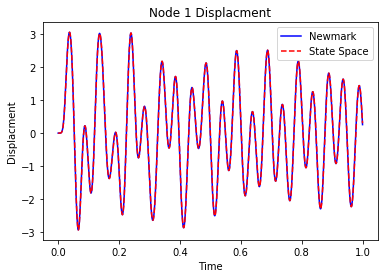

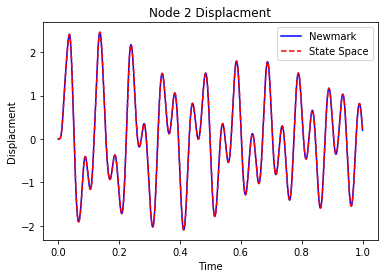

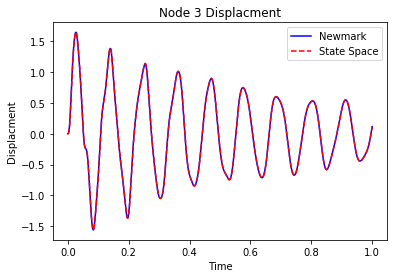

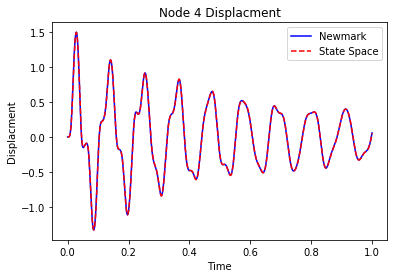

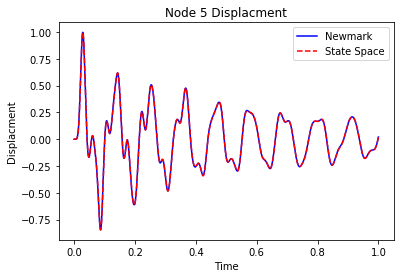

In [18]:
for i in range(nm):
    figure();     plot(t,disp[i,:],'b',label='Newmark'); plot(t,x[i,:],'r--',label='State Space');
    xlabel('Time'); ylabel('Displacment'); title('Node %d Displacment'%(i+1));  legend();          

지배방정식을 모드좌표계로 변환하면 다음과 같다.

$[M]\phi\{\ddot q (t)\}+[C]\phi\{\dot q (t)\}+[K]\phi q(t)=\{f(t)\}$

양변에 $\phi^T$를 곱하면 다음과 같다.

$\phi^T[M]\phi\{\ddot q (t)\}+\phi^T[C]\phi\{\dot q (t)\}+\phi^T[K]\phi q(t)=\phi^T\{f(t)\}$

양변에 $\left[\phi^T[M]\phi\right]^{-1}$을 곱하면 다음과 같다.

$\{\ddot q (t)\}+[C_n]\{\dot q (t)\}+[K_n] q(t)= \Phi \{f(t)\}$

$where,$

$\Phi = \left[\phi^T[M]\phi\right]^{-1} \phi^T$

상기 식을 모드 별로 기술하면 다음과 같다.

$\ddot q_n (t)+2\zeta_n\omega_n\dot q_n (t)+\omega_n^2 q_n(t)= f_n(t)$

$where,$

$f_n(t)=\Phi_{n,2}F_0sin(2\pi ft)$

상기 식의 해는 다음과 같이 과도 해 및 정상 해의 조합으로 표현할 수 있다.

$q_n(t)=A_1 sin(\omega t+\theta_1) + A_2 sin(\omega_d t + \theta_2)$

$where,$

$\omega = 2\pi f = 가진 주파수 (rad/s)$

$\omega_d = \omega_n \sqrt{1-\zeta^2} = 감쇠 고유진동수$

$A_1 = \frac{\Phi_{n,2}F_0}{\sqrt{(\omega^2-\omega_n^2)^2+(2\zeta\omega\omega_n)^2}}$

$\theta_1=tan^{-1}\left(\frac{2\zeta\omega\omega_n}{\omega_n^2-\omega^2}\right)$

## 2. Inverse Problem

## MPC

MPC로 Force Reconstruction을 할 수 있다.

$N_p=N_c=1$인 경우 MPC 식은 다음과 같다.

(1) 상태공간 방정식

$x_{k+1}=Ax_k+Bu_k$

$y_{k+1}=Gx_{k+1}$

(2) MPC 식

$y_{k+1}=Fx_k+\Phi u_k$

$F=GA$

$\Phi=GB$

$u_k = (\Phi^T\Phi)^{-1}\Phi^T(Rs-Fx_k)$

In [19]:
F = G@A
Phi = G@B

In [20]:
x_wn = x + (random.rand(2*nm,N)-0.5)*1e-3

In [21]:
# Rs =stack(x[0:2,:],x[3:5,:])
Rs = x_wn[0:5,:]

In [22]:
r = 0 * identity(nm)

In [23]:
u_es = zeros([nm,N])
for i in range(N-1):
    u_es[:,i]=inv(Phi.T@Phi+r)@Phi.T@(Rs[:,i+1]-F@x_wn[:,i])

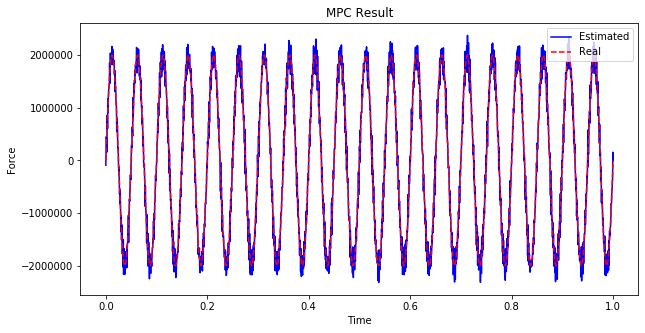

In [24]:
figure(figsize=(10,5))
plot(t,u_es[2,:],'b',label='Estimated')
plot(t,u[2,:],'r--',label='Real');
legend(loc='upper right');
title('MPC Result');
xlabel('Time')
ylabel('Force');